# Face Recognition


For this Project, we'll be using a pre-trained model which represents ConvNet activations using a "channels last" convention.

In other words, a batch of images will be of shape $(m, n_H, n_W, n_C)$. 

The FaceNet model takes a lot of data and a long time to train. So, we'll use transfer learning. The network architecture follows the Inception model from [Szegedy *et al*..](https://arxiv.org/abs/1409.4842) 


- This network uses 160x160 dimensional RGB images as its input. Specifically, a face image (or batch of $m$ face images) as a tensor of shape $(m, n_H, n_W, n_C) = (m, 160, 160, 3)$
- Any input images need to be scaled to 160x160.
- The output is a matrix of shape $(m, 128)$ that encodes each input face image into a 128-dimensional vector

## Import Packages

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras_facenet import FaceNet
import tensorflow as tf

In [2]:
model = FaceNet()

### Extract the face from the image

In [3]:
def extract_face(image_path):
    
    #load the image , convert it to RGB
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    #extract the bounding box which is represented by the tob left corner coordinates and the width and height of the box
    detections = model.extract(image, threshold=0.95)
    
    x1, y1, width, height = detections[0]['box']
    
    # calculate the bottom right coordinates of the box
    x2, y2 = x1 + width, y1 + height
    
    # extract the face from the image and resize it to be (160,160,3) for the facenet
    face = image[y1:y2, x1:x2]
    face = cv2.resize(face, (160, 160))
    #face = np.around(face / 255.0, decimals=12)
    
    return face

### Make the bounding box around the face with the preson's name above it

In [4]:
def bounding_box(image , height, identity):
    
    # image : the person we want to recognize
    # height : the height of the bounding box
    # identity : the name of the person
    
    # Scale the thickness and font size parameters based on the size of the bounding box
    thickness = int(height/30)
    font_scale = height/120

    # Draw the bounding box and text with the scaled parameters
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), thickness)
    cv2.putText(image, identity, (x1, y1-thickness*3), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 255, 0), thickness)

### Make the face database

In [5]:
face_db = {
    # get the encoded 128-dimentional vector for the each person's face
    "hazem": model.embeddings([extract_face('images/hazem.jpg')]),
    "Adham": model.embeddings([extract_face('images/adham.jfif')]),
    "Ahmed": model.embeddings([extract_face('images/ahmed.jfif')]),
    "Bahaa": model.embeddings([extract_face('images/bahaa.jfif')]),
    "seif": model.embeddings([extract_face('images/seif.jfif')]),
}

1/1 [==============================] - 0s 98ms/step


## Recognize the face

By using a 128-neuron fully connected layer as its last layer, the model ensures that the output is an encoding vector of size 128. we then use the encodings to compare two face images as follows:

<img src="images/distance.png\" style="width:680px;height:250px;">
<caption><center> <u> <font color='purple'> <b>Figure 2:By computing the distance between two encodings and thresholding, we can determine if the two pictures represent the same person</center></caption>

So, an encoding is a good one if:

- The encodings of two images of the same person are quite similar to each other.
- The encodings of two images of different persons are very different.

The triplet loss function formalizes this, and tries to "push" the encodings of two images of the same person (Anchor and Positive) closer together, while "pulling" the encodings of two images of different persons (Anchor, Negative) further apart.
    
<img src="images/triplet_comparison.png" style="width:280px;height:150px;"><br>
<caption><center> <u> <font color='purple'> 

In [6]:
def recognize_person(face):
    
    # get the encoded 128-dimentional vector for the face
    embeddings = model.embeddings([face])
    
    # Initialize "min_dist" to a large value, say 100 (≈1 line)
    min_dist = 100
        
    #Loop over the database dictionary's names and encodings.
    for (name, db_enc) in face_db.items():
        print(f"Comparing to {name}")
        # Compute L2 distance between the target "encoding" and the current db_enc from the database. (≈ 1 line)
        dist = np.linalg.norm(embeddings - db_enc)
        print(f"distance = {dist}")
        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if dist < min_dist:
            min_dist = dist
            identity = name
            
    return identity

Here are some examples of distances between the encodings between three individuals:

<img src="images/distance_matrix.png" style="width:380px;height:200px;"><br>
<caption><center> <u> <font color='purple'> <b>Figure 4:</b></u> <br>  <font color='purple'> Example of distance outputs between three individuals' encodings</center></caption>

Now we can use this model to perform face recognition!

## Test 1

1/1 [==============================] - 0s 109ms/step
Comparing to hazem
distance = 1.2895879745483398
Comparing to Adham
distance = 1.2598648071289062
Comparing to Ahmed
distance = 0.46108153462409973
Comparing to Bahaa
distance = 1.376621127128601
Comparing to seif
distance = 1.4243355989456177
the person is Ahmed
1/1 [==============================] - 0s 118ms/step
Comparing to hazem
distance = 1.2787678241729736
Comparing to Adham
distance = 1.0719705820083618
Comparing to Ahmed
distance = 1.2022448778152466
Comparing to Bahaa
distance = 0.3643103241920471
Comparing to seif
distance = 1.2835851907730103
the person is Bahaa


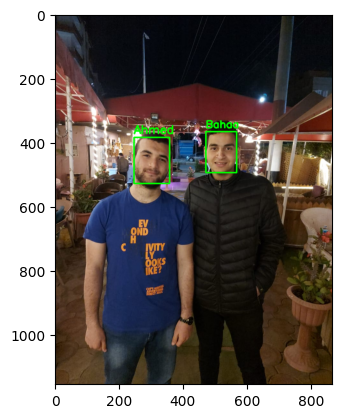

In [7]:
image = cv2.imread("images/ahmed_and_bahaa.jfif")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
detections = model.extract(image, threshold=0.95)

embeddings = []
boxes = []
for detection in detections:
    x1, y1, width, height = detection['box']
    x2, y2 = x1 + width, y1 + height
    
    boxes.append((x1, y1, x2, y2))
    
    face = image[y1:y2, x1:x2]
    face = cv2.resize(face, (160, 160))
    
    identity = recognize_person(face)
    print(f'the person is {identity}')
    bounding_box(image, height, identity)
    
plt.imshow(image)

## Test 2

1/1 [==============================] - 0s 96ms/step
Comparing to hazem
distance = 1.3695530891418457
Comparing to Adham
distance = 1.3829213380813599
Comparing to Ahmed
distance = 1.4537678956985474
Comparing to Bahaa
distance = 1.5100750923156738
Comparing to seif
distance = 1.5429843664169312


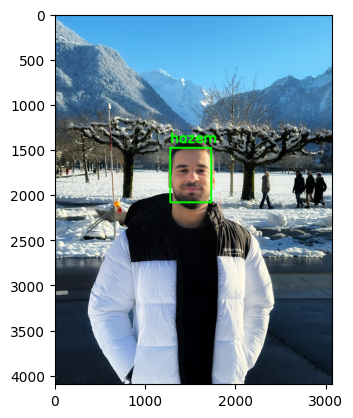

In [8]:
image = cv2.imread("images/hazem3.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

detections = model.extract(image, threshold=0.95)

x1, y1, width, height = detections[0]['box']
x2, y2 = x1 + width, y1 + height
        
face = image[y1:y2, x1:x2]
face = cv2.resize(face, (160, 160))

identity = recognize_person(image)
bounding_box(image, height, identity)


plt.imshow(image)

## Test 3

1/1 [==============================] - 0s 107ms/step
Comparing to hazem
distance = 1.3986800909042358
Comparing to Adham
distance = 1.310157299041748
Comparing to Ahmed
distance = 1.379671573638916
Comparing to Bahaa
distance = 1.323440432548523
Comparing to seif
distance = 0.5947600603103638


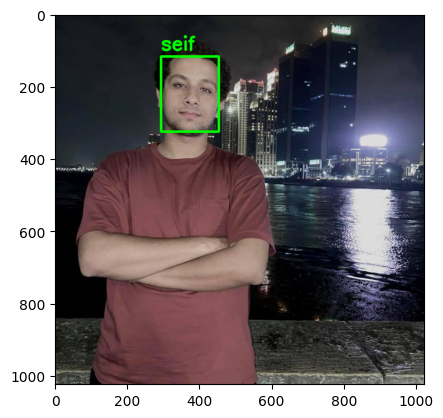

In [9]:
image = cv2.imread("images/seif1.jfif")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
detections = model.extract(image, threshold=0.95)

x1, y1, width, height = detections[0]['box']
x2, y2 = x1 + width, y1 + height
        
face = image[y1:y2, x1:x2]
face = cv2.resize(face, (160, 160))

identity = recognize_person(face)
bounding_box(image, height, identity)


plt.imshow(image)